Project - SCOTT MCCOY.ipynb

### **Using Industry Indicators to Predict Stock Returns** 

For this project, I will compare different industry classification systems and how well each can be used to explain stock returns for early and late 2020. 

The three systems used are:
*  Global Industry Classification System (GICS)
*  North American Industry Classification System (NAICS)
*  Standard Industrial Classification (SIC). 

Each of these systems has multiple levels of specificity. For example the GICS system ranges from the most general (Sector - 11 classifications) to the most specific (Sub-Industry - 158 classifications). For each of these systems, I will analyze four levels of specificity to see what is the ideal level and system for analyzing, explaining, and predicting 2020 stock returns.

<br>

The dataset consists of stocks in the Russell 3000 index, for which there are about 2700 companies with complete data on industry and returns. 

The analysis takes on two levels:
* Predicting stock returns during the initial pandemic recession (Jan - Mar)
* Predicting stock returns during the later pandemic recovery (Apr - Dec)

**Classification Systems**

> GICS codes:

GICS website - https://www.msci.com/gics

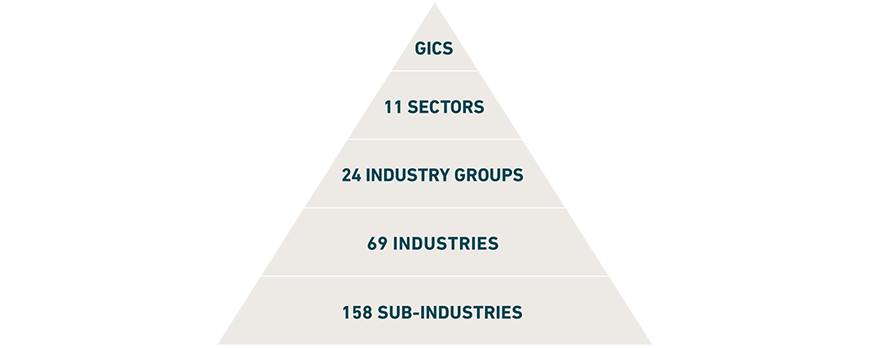

> NAICS Codes:

https://www.census.gov/eos/www/naics/faqs/faqs.html - NAICS code info

https://www.census.gov/eos/www/naics/downloadables/downloadables.html - lookup table

"The first two digits designate the economic sector, the third digit designates the subsector, the fourth digit designates the industry group, the fifth digit designates the NAICS industry, and the sixth digit designates the national industry"

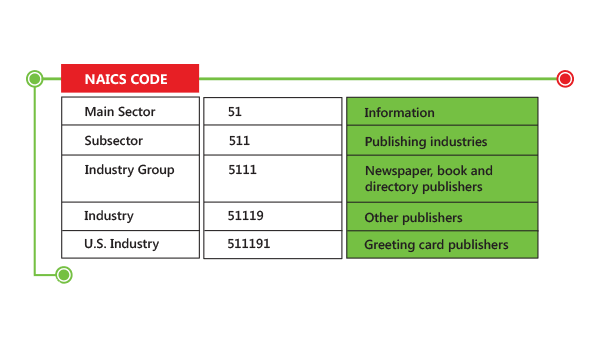

> SIC Codes:

https://siccode.com/page/what-is-a-sic-code - SIC code info

"The first two digits of the code identify the major industry group, the third digit identifies the industry group and the fourth digit identifies the industry."



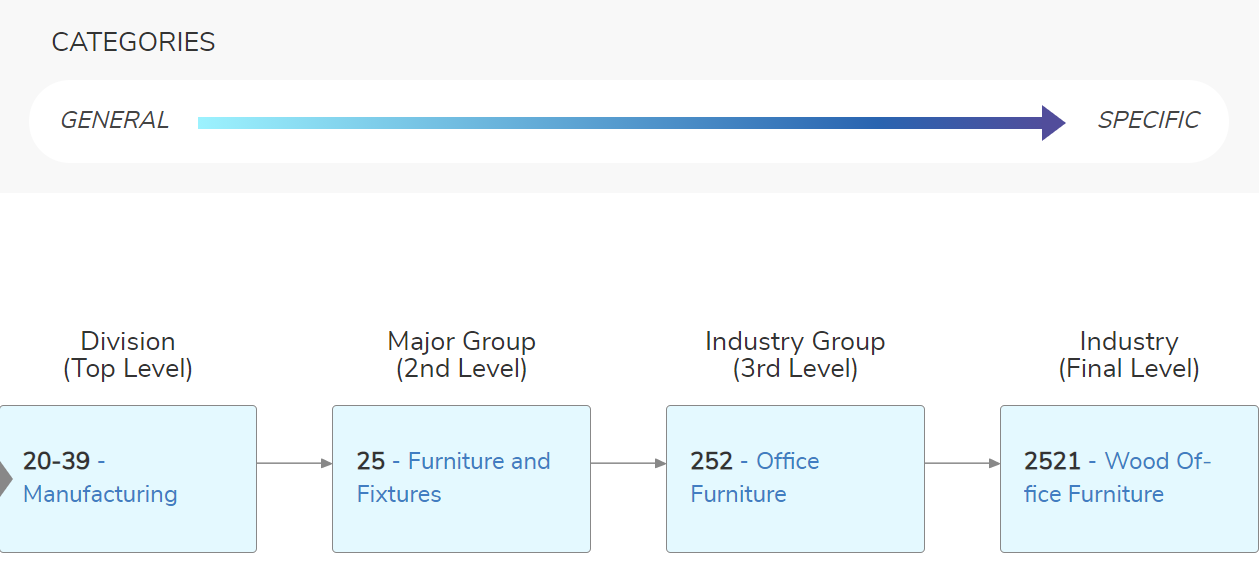

# Loading and Pre-Processing

In [1]:
!pip install pandasql

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mstats
import pandasql as ps
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

Loading data:

In [3]:
# loading csvs
df1 = pd.read_csv('../temp1.csv') # tickers and returns (early & late 2020)
df2 = pd.read_csv('industry_codes.csv') # wrds industry codes - 

Adding naics and sic subset codes:

In [4]:
# naics
df2['nsector'] = df2.naics.astype('str').str[:2]   # first two digits of naics code represents sector
df2['nsubsector'] = df2.naics.astype('str').str[:3]
df2['nindgroup'] = df2.naics.astype('str').str[:4]
df2['nindustry'] = df2.naics.astype('str').str[:5]
#sic
df2['sic'] = df2.sic.astype('str').str.zfill(4) # left padding sic codes to 4 digit
df2['sdivision'] = df2.sic.astype('str').str[:2] # first two digits of sic code represnts division
df2['smig'] = df2.sic.astype('str').str[:2]
df2['sig'] = df2.sic.astype('str').str[:3]
df2['sindustry'] = df2.sic.astype('str').str[:4]

#merging outcomes and industry codes/names
df = df1.merge(df2, how = 'left', left_on = 'TICKER', right_on = 'tic')
df = df[(df['RetEarly2020'] != "0") & (df['RetLate2020'] != "0") & (df['RetEarly2020'] != '#VALUE!') & (df['RetLate2020'] != '#VALUE!')]

Adding lookup tables to match codes to industry names:

In [5]:
# GICS
gsector = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'gsector')
ggroup = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'ggroup')
gind = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'gind')
gsubind = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'gsubind')

# NAICS
nsector = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'nsector')
nsector['Code'] = nsector['Code'].astype('str')                                              # changing to string data type to match 
nsubsector = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'nsubsector')
nsubsector['Code'] = nsubsector['Code'].astype('str')
nindgroup = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'nindgroup')
nindgroup['Code'] = nindgroup['Code'].astype('str')
nindustry = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'nindustry')
nindustry['Code'] = nindustry['Code'].astype('str')

# SIC
sdivision = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'sdivision')
sdivision['Code'] = sdivision['Code'].astype('str').str.zfill(2)
smig = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'smig')
smig['Code'] = smig['Code'].astype('str').str.zfill(2)
sig = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'sig')
sig['Code'] = sig['Code'].astype('str').str.zfill(3)
sindustry = pd.read_excel('Industry_Code_Lookups.xlsx', sheet_name = 'sindustry')
sindustry['Code'] = sindustry['Code'].astype('str').str.zfill(4)


Joining industry classification codes with industry names:

In [6]:
# creating dataframes for each subset of industry classification
def ind_codes(vari):
  query = f"""SELECT a.tic, a.conm,a.RetEarly2020, a.RetLate2020 ,b.Code AS icode, b.Name AS iname  FROM df AS a 
  LEFT JOIN {vari} AS b ON a.{vari} = b.Code"""
  new_df = ps.sqldf(query)
  new_df = new_df[new_df['iname'].str.len() > 0]

  return new_df

dfg1 = ind_codes('gsector') # GICS
dfg2 = ind_codes('ggroup')
dfg3 = ind_codes('gind')
dfg4 = ind_codes('gsubind')
dfn1 = ind_codes('nsector') # NAICS
dfn2 = ind_codes('nsubsector')
dfn3 = ind_codes('nindgroup')
dfn4 = ind_codes('nindustry')
dfs1 = ind_codes('sdivision') # SIC
dfs2 = ind_codes('smig')
dfs3 = ind_codes('sig')
dfs4 = ind_codes('sindustry')

In [7]:
print('Unique GICS in dataset: ', len(dfg1.iname.unique()), len(dfg2.iname.unique()), len(dfg3.iname.unique()), len(dfg4.iname.unique()))
print('Unique NAICS in dataset: ', len(dfn1.iname.unique()), len(dfn2.iname.unique()), len(dfn3.iname.unique()), len(dfn4.iname.unique()))
print('Unique SIC in dataset: ', len(dfs1.iname.unique()), len(dfs2.iname.unique()), len(dfs3.iname.unique()), len(dfs4.iname.unique()))

Unique GICS in dataset:  11 24 66 146
Unique NAICS in dataset:  18 80 230 386
Unique SIC in dataset:  10 67 198 215


In [8]:
num_unique = pd.DataFrame({'GICS':[len(dfg1.iname.unique()), len(dfg2.iname.unique()), len(dfg3.iname.unique()), len(dfg4.iname.unique())],
                          'NAICS': [len(dfn1.iname.unique()), len(dfn2.iname.unique()), len(dfn3.iname.unique()), len(dfn4.iname.unique())],
                          'SIC':[len(dfs1.iname.unique()), len(dfs2.iname.unique()), len(dfs3.iname.unique()), len(dfs4.iname.unique())]})
num_unique

,GICS,NAICS,SIC
0,11,18,10
1,24,80,67
2,66,230,198
3,146,386,215


In [9]:
num_total = pd.DataFrame({'GICS':[len(gsector.Name.unique()), len(ggroup.Name.unique()), len(gind.Name.unique()), len(gsubind.Name.unique())],
                        'NAICS':[len(nsector.Name.unique()), len(nsubsector.Name.unique()), len(nindgroup.Name.unique()), len(nindustry.Name.unique())],
                        'SIC':[len(sdivision.Name.unique()), len(smig.Name.unique()), len(sig.Name.unique()), len(sindustry.Name.unique())]})
num_total

,GICS,NAICS,SIC
0,11,20,10
1,25,113,83
2,68,398,416
3,157,973,1007


In [10]:
num_unique / num_total

,GICS,NAICS,SIC
0,1.000000,0.900000,1.000000
1,0.960000,0.707965,0.807229
2,0.970588,0.577889,0.475962
3,0.929936,0.396711,0.213505


In [11]:
print(dfg1.shape, dfg2.shape, dfg3.shape, dfg4.shape)
print(dfn1.shape, dfn2.shape, dfn3.shape, dfn4.shape)
print(dfs1.shape, dfs2.shape, dfs3.shape, dfs4.shape)

(2668, 6) (2668, 6) (2594, 6) (2582, 6)
(2666, 6) (2666, 6) (2666, 6) (2666, 6)
(2668, 6) (2668, 6) (2526, 6) (1771, 6)


# Regressions

## GICS

**GICS-1**

In [12]:
gresults = pd.DataFrame()

In [13]:
y1 = dfg1['RetEarly2020'].astype('float')
y2 = dfg1['RetLate2020'].astype('float')
x = dfg1['iname']
x = pd.get_dummies(x, columns=['iname'])
 
mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

gresults = gresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     35.81
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           2.98e-66
Time:                        20:30:41   Log-Likelihood:                -526.72
No. Observations:                2668   AIC:                             1075.
Df Residuals:                    2657   BIC:                             1140.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Consumer Discretiona

**GICS-2**

In [14]:
y1 = dfg2['RetEarly2020'].astype('float')
y2 = dfg2['RetLate2020'].astype('float')
x = dfg2['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

gresults = gresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     17.25
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.46e-64
Time:                        20:30:44   Log-Likelihood:                -508.83
No. Observations:                2668   AIC:                             1066.
Df Residuals:                    2644   BIC:                             1207.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

**GICS-3**

In [15]:
y1 = dfg3['RetEarly2020'].astype('float')
y2 = dfg3['RetLate2020'].astype('float')
x = dfg3['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

gresults = gresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     7.926
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.43e-63
Time:                        20:30:45   Log-Likelihood:                -452.38
No. Observations:                2594   AIC:                             1037.
Df Residuals:                    2528   BIC:                             1424.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

**GICS-4**

In [16]:
y1 = dfg4['RetEarly2020'].astype('float')
y2 = dfg4['RetLate2020'].astype('float')
x = dfg4['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

gresults = gresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     4.335
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.47e-52
Time:                        20:30:46   Log-Likelihood:                -393.99
No. Observations:                2582   AIC:                             1080.
Df Residuals:                    2436   BIC:                             1935.
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

## NAICS

**NAICS-1**

In [17]:
nresults = pd.DataFrame()

In [18]:
y1 = dfn1['RetEarly2020'].astype('float')
y2 = dfn1['RetLate2020'].astype('float')
x = dfn1['iname']
x = pd.get_dummies(x, columns=['iname'])
 
mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())


nresults = nresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     11.96
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.48e-32
Time:                        20:30:47   Log-Likelihood:                -597.24
No. Observations:                2666   AIC:                             1230.
Df Residuals:                    2648   BIC:                             1336.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

**NAICS-2**

In [19]:
y1 = dfn2['RetEarly2020'].astype('float')
y2 = dfn2['RetLate2020'].astype('float')
x = dfn2['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

nresults = nresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     5.534
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           3.79e-46
Time:                        20:30:47   Log-Likelihood:                -487.65
No. Observations:                2666   AIC:                             1135.
Df Residuals:                    2586   BIC:                             1606.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

**NAICS-3**

In [20]:
y1 = dfn3['RetEarly2020'].astype('float')
y2 = dfn3['RetLate2020'].astype('float')
x = dfn3['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

nresults = nresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     2.484
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.81e-26
Time:                        20:30:48   Log-Likelihood:                -416.11
No. Observations:                2666   AIC:                             1292.
Df Residuals:                    2436   BIC:                             2647.
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     3.042
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.33e-40
Time:                        20:30:48   Log-Likelihood:                -3647.0
No. Observations:                2666   AIC:                             7754.
Df Residuals:                    2436   BIC:                             9108.
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

**NAICS-4**

In [21]:
y1 = dfn4['RetEarly2020'].astype('float')
y2 = dfn4['RetLate2020'].astype('float')
x = dfn4['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

nresults = nresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.672
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.10e-12
Time:                        20:30:48   Log-Likelihood:                -364.31
No. Observations:                2666   AIC:                             1501.
Df Residuals:                    2280   BIC:                             3774.
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     2.425
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.35e-36
Time:                        20:30:49   Log-Likelihood:                -3524.6
No. Observations:                2666   AIC:                             7821.
Df Residuals:                    2280   BIC:                         1.009e+04
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## SIC

**SIC-1**

In [22]:
sresults = pd.DataFrame()

In [23]:
y1 = dfs1['RetEarly2020'].astype('float')
y2 = dfs1['RetLate2020'].astype('float')
x = dfs1['iname']
x = pd.get_dummies(x, columns=['iname'])
 
mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

sresults = sresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     16.93
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.93e-27
Time:                        20:30:49   Log-Likelihood:                -621.03
No. Observations:                2668   AIC:                             1262.
Df Residuals:                    2658   BIC:                             1321.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

**SIC-2**

In [21]:
y1 = dfs2['RetEarly2020'].astype('float')
y2 = dfs2['RetLate2020'].astype('float')
x = dfs2['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

sresults = sresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.798
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           2.64e-42
Time:                        21:13:25   Log-Likelihood:                -512.29
No. Observations:                2668   AIC:                             1159.
Df Residuals:                    2601   BIC:                             1553.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

**SIC-3**

In [24]:
y1 = dfs3['RetEarly2020'].astype('float')
y2 = dfs3['RetLate2020'].astype('float')
x = dfs3['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

sresults = sresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     2.570
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           3.12e-25
Time:                        20:31:09   Log-Likelihood:                -446.62
No. Observations:                2526   AIC:                             1289.
Df Residuals:                    2328   BIC:                             2444.
Df Model:                         197                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

**SIC-4**

In [25]:
y1 = dfs4['RetEarly2020'].astype('float')
y2 = dfs4['RetLate2020'].astype('float')
x = dfs4['iname']
x = pd.get_dummies(x, columns=['iname'])

mod1 = sm.OLS(y1, x)
res1 = mod1.fit()
print(res1.summary())

mod2 = sm.OLS(y2, x)
res2 = mod2.fit()
print(res2.summary())

sresults = sresults.append({'Adj_rsqrd_Early': res1.rsquared_adj, 'Adj_rsqrd_Late':res2.rsquared_adj,
                           'Sig_Coef_Early': (res1.pvalues < .05).sum(), 'Sig_Coef_Late':(res2.pvalues < .05).sum()}, ignore_index=True)

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     1.905
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           5.31e-12
Time:                        20:31:10   Log-Likelihood:                -438.49
No. Observations:                1771   AIC:                             1307.
Df Residuals:                    1556   BIC:                             2485.
Df Model:                         214                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

# Results

## Comparing GICS/NAICS/SIC

The tables below show the regression results for models by:
* Type of Industry Indicator (GICS, NAICS, SIC)
* Early vs Late 2020
* Level of Specificity (Num_Unique)
  * Broad Industry - Fewer unique industries
  * Specific Industry - Many unique industries


> GICS

In [24]:
gresults.index = [len(dfg1.iname.unique()), len(dfg2.iname.unique()), len(dfg3.iname.unique()), len(dfg4.iname.unique())]
gresults.index.name = 'Num_Unique'
gresults

,Adj_rsqrd_Early,Adj_rsqrd_Late,Sig_Coef_Early,Sig_Coef_Late
Num_Unique,,,,
11,0.115457,0.092359,11.0,10.0
24,0.122945,0.102984,23.0,22.0
66,0.147931,0.136639,56.0,50.0
146,0.157788,0.183491,112.0,84.0


> NAICS

In [25]:
nresults.index  = [len(dfn1.iname.unique()), len(dfn2.iname.unique()), len(dfn3.iname.unique()), len(dfn4.iname.unique())]
nresults.index.name = 'Num_Unique'
nresults

,Adj_rsqrd_Early,Adj_rsqrd_Late,Sig_Coef_Early,Sig_Coef_Late
Num_Unique,,,,
18,0.065346,0.069405,17.0,14.0
80,0.118474,0.123370,66.0,58.0
230,0.113097,0.149253,132.0,104.0
386,0.088525,0.170758,171.0,115.0


> SIC

In [26]:
sresults.index = [ len(dfs1.iname.unique()), len(dfs2.iname.unique()), len(dfs3.iname.unique()), len(dfs4.iname.unique())]
sresults.index.name = 'Num_Unique'
sresults

,Adj_rsqrd_Early,Adj_rsqrd_Late,Sig_Coef_Early,Sig_Coef_Late
Num_Unique,,,,
10,0.051015,0.064907,8.0,8.0
67,0.106131,0.114422,56.0,48.0
198,0.109120,0.115062,128.0,87.0
215,0.098662,0.136705,96.0,75.0


In general as the specificity of an industry indicator system increases, the explanitory power of the fixed effect regressions also increases. However, this increases comes with the tradeoff that it becomes more difficult to interpret the results when there are so many industry coefficients.

Since we are comparing adjusted r-squared values, having more x variables will penalize adjusted r-squared. For NAICS and SIC indicators, the adjusted r-squared for early 2020 actually decreases at the most specific indicator level. 

For this application, the GICS indicators seem to do better explaining early and late 2020 returns compared to NAICS and SIC, especially when the number of unique indicators is low.

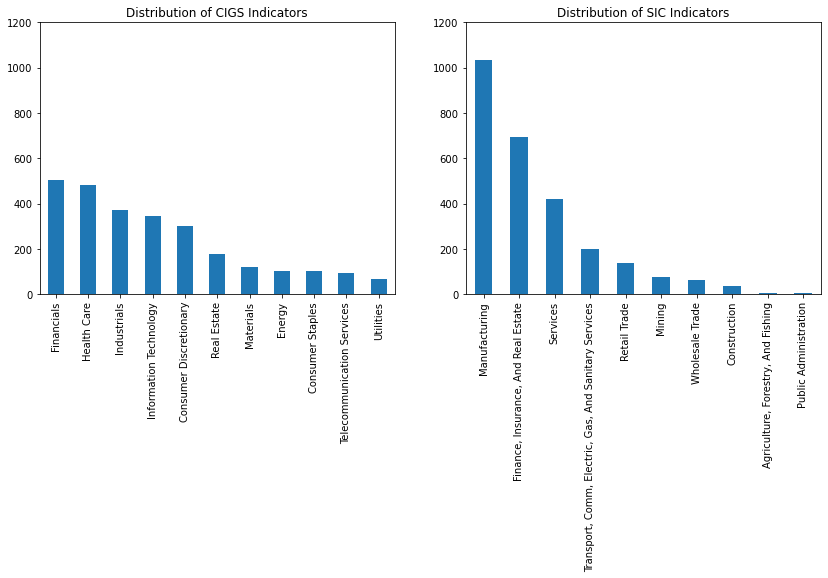

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.title.set_text('Distribution of CIGS Indicators')
ax1.set_ylim([0, 1200])
ax2.title.set_text('Distribution of SIC Indicators')
ax2.set_ylim([0, 1200])
dfg1.iname.value_counts().plot.bar(ax = ax1)
dfs1.iname.value_counts().plot.bar(ax = ax2)
plt.show()

One reason why GICS performed better could be that the companies in our dataset are more balanced by industry than in SIC or NAICS.

The above plot shows which industry indicators make up our dataset for GICS and SIC. For SIC, almost half of companies are classified as "Manufacturing". SIC also has very broad catch-all indicators like "Finance, Insurance, and Real Estate" that would group very different companies together. 

Though it is not a uniform distribution, the GICS indicators are much more balanced in this dataset.



## Comparing Broad vs Specific Indicators - GICS

We saw earlier that using more numerous and specific industry indicators explains more of the variation in early and late 2020 return outcomes. This is likely because using the broad indicators groups together companies with very different business models, where the specific indicators mean that companies with the same code are more likely to be similar. 

Below, regression results are compared for the most broad (Sector) and most specific (sub-industry) GICS indicators. 


In [26]:
# Sector Regression
y1 = dfg1['RetEarly2020'].astype('float')
y2 = dfg1['RetLate2020'].astype('float')
x = dfg1.icode.astype('int').astype('str') + '_' + dfg1.iname
x = pd.get_dummies(x, columns=['iname'])
mod1 = sm.OLS(y1, x)
res1 = mod1.fit()

# Sub-Industry Regression
y1 = dfg4['RetEarly2020'].astype('float')
y2 = dfg4['RetLate2020'].astype('float')
x = dfg4.icode.astype('int').astype('str') + '_' + dfg4.iname
x = pd.get_dummies(x, columns=['iname'])
mod2 = sm.OLS(y1, x)
res2 = mod2.fit()

> Information Technology

The information sector has an average early 2020 return of -21.7%. When we compare that to the averages of the sub-industries that fall within the larger IT sector, we see that most are relatively close together.

In [27]:
# IT sector
res1.params[7:8]

45_Information Technology   -0.216825
dtype: float64

In [28]:
# IT sub-industries
res2.params[113:125]

45102010_IT Consulting & Other Services               -0.236266
45102020_Data Processing & Outsourced Services        -0.312362
45103010_Application Software                         -0.159787
45103020_Systems Software                             -0.101528
45201020_Communications Equipment                     -0.246546
45202030_Technology Hardware, Storage & Peripherals   -0.316359
45203010_Electronic Equipment & Instruments           -0.297740
45203015_Electronic Components                        -0.319009
45203020_Electronic Manufacturing Services            -0.289516
45203030_Technology Distributors                      -0.352021
45301010_Semiconductor Equipment                      -0.221918
45301020_Semiconductors                               -0.229218
dtype: float64

> Health Care

The Health Care sector has an average early 2020 return of -14%. When we compare that to the averages of the sub-industries that fall within the larger sector, we see that there is much more variation. Returns range from -35% at the lowest to 3% at the highest. 

This is one sector that likely benefits from the increased specificity of having more industry indicators.

In [29]:
res1.params[5:6]

35_Health Care   -0.139677
dtype: float64

In [30]:
res2.params[87:97]

35101010_Health Care Equipment            -0.090319
35101020_Health Care Supplies             -0.163101
35102010_Health Care Distributors          0.029810
35102015_Health Care  Services            -0.179376
35102020_Health Care Facilities           -0.350752
35102030_Managed Health Care              -0.191974
35103010_Health Care Technology           -0.089736
35201010_Biotechnology                    -0.113588
35202010_Pharmaceuticals                  -0.222985
35203010_Life Sciences Tools & Services   -0.173646
dtype: float64

## Out of Sample Regressions

Another issue with the very specific industry indicators is that there might not be enough companies in the dataset to accurately generalize and make accurate out of sample predictions.

Below are results of out of sample predictions for 2 regressions; one with very broad industry indicators and one with specific industry indicators.

In [113]:
dfg1['RetEarly2020'].astype('float').std()

0.3140791291611769

In [104]:
# Sector Regression - Broad
y1 = dfg1['RetEarly2020'].astype('float')
y2 = dfg1['RetLate2020'].astype('float')
x = dfg1.icode.astype('int').astype('str') + '_' + dfg1.iname
x = pd.get_dummies(x, columns=['iname'])

X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.2, random_state = 42)

reg1 = LinearRegression().fit(X_train, y_train)
pred = reg1.predict(X_test)

mse1 = np.sqrt(np.mean((y_test - pred)**2))
mse1

scores = cross_val_score(reg1, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
scores.mean()

-0.2854925334883215

In [105]:
# Group Regression - Broader
y1 = dfg2['RetEarly2020'].astype('float')
y2 = dfg2['RetLate2020'].astype('float')
x = dfg2.icode.astype('int').astype('str') + '_' + dfg1.iname
x = pd.get_dummies(x, columns=['iname'])

X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.2, random_state = 42)

reg1 = LinearRegression().fit(X_train, y_train)
pred = reg1.predict(X_test)

mse1 = np.sqrt(np.mean((y_test - pred)**2))
mse1

scores = cross_val_score(reg1, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
scores.mean()

-0.2845003482460235

In [109]:
# Industry Regression - Specific
y1 = dfg3['RetEarly2020'].astype('float')
y2 = dfg3['RetLate2020'].astype('float')
x = dfg3.icode.astype('int').astype('str') + '_' + dfg3.iname
x = pd.get_dummies(x, columns=['iname'])

X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.2, random_state=42)

reg2 = LinearRegression().fit(X_train, y_train)
pred = reg2.predict(X_test)

mse2 = np.sqrt(np.mean((y_test - pred)**2))
mse2

scores = cross_val_score(reg2, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
scores[1:].mean()

-0.2961748369748402

For out of sample prediction, the broad industry indicators actually have a lower RMSE than the second most specific (industry). The most specific indicator (sub-industry) could not be used since there were so many codes that only had a single company. 

With so many different industries, the specific indicator regression likely does not have enough data to make good predictions.

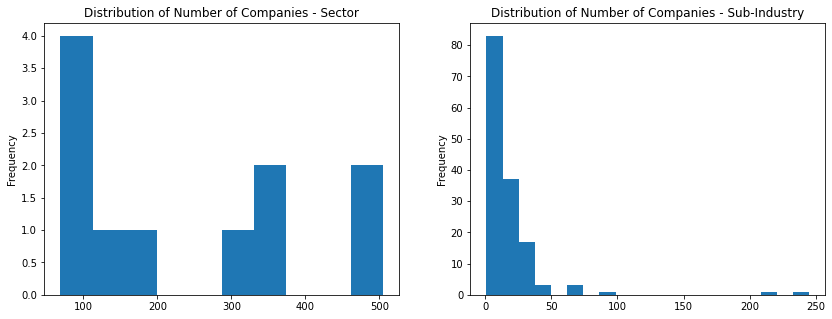

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.title.set_text('Distribution of Number of Companies - Sector')
ax2.title.set_text('Distribution of Number of Companies - Sub-Industry')
dfg1.iname.value_counts().plot.hist(ax = ax1)
dfg4.iname.value_counts().plot.hist(ax = ax2, bins = 20)
plt.show()

The above two plots show the distribution of the number of companies in our dataset that have the same classification code.

* For the broad classification on the left, all of the sectors have at least or nearly 100 different companies with the same classification.
* For the specific classification on the right, almost all of the sub-industries have less than 25 different companies with the same classification. Less than 12 is by far the most common. 

With these results, it makes sense that the very specific classifications would have a difficult time generalizing and making accurate out of sample predictions.